<a href="https://colab.research.google.com/github/Gongsoo/Python3/blob/main/study/paper/papering111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/paper"

/content/drive/MyDrive/paper


In [3]:
#!unzip -qq "/content/drive/MyDrive/paper/papering.zip"

In [20]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, SubsetRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [138]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':15,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

In [7]:
def seed_everything(seed):
    deterministic = False
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if deterministic :
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

In [206]:
all_img_list = glob.glob('/content/drive/MyDrive/paper/train/*/*')

In [207]:
train = pd.DataFrame(columns=['img_path', 'label'])
train['img_path'] = all_img_list
train['label'] = train['img_path'].apply(lambda x : str(x).split('/')[-2])

In [208]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])

In [209]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms = None,transforms_no_rotate=None, trainsforms_rotate = None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        self.transforms_no_rotate = transforms_no_rotate
        self.transforms_rotate = trainsforms_rotate
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        rotate_label = [1,2,4,6,7,8,9,10,11,12,15,16,17,18]
        image = cv2.imread(img_path)

        if self.label_list is not None:
            label = self.label_list[index]

            if self.transforms_rotate is not None and label in rotate_label :
                image = self.transforms_rotate(image=image)['image']
            elif self.transforms_no_rotate is not None and label not in rotate_label :
                image = self.transforms_no_rotate(image=image)['image']
            elif self.transforms_rotate is None and self.transforms_no_rotate is None and self.transforms is not None:
                image = self.transforms(image=image)['image']

            return image, label
        else:
            if self.transforms is not None :
              image = self.transforms(image=image)['image']
            return image
        
    def __len__(self):
        return len(self.img_path_list)


In [143]:
def calculate_norm(dataset,test):
    if test :
      mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x in tqdm(dataset)])
    else :
      mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in tqdm(dataset)])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()/255.
    mean_g = mean_[:, 1].mean()/255.
    mean_b = mean_[:, 2].mean()/255.

    if test :
      std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x in tqdm(dataset)])
    else :
      std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in tqdm(dataset)])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()/255.
    std_g = std_[:, 1].mean()/255.
    std_b = std_[:, 2].mean()/255.
    
    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)
     

In [144]:
tmp_transforms = A.Compose([
                            ToTensorV2()
                            ])

In [210]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, tmp_transforms,None,None)

In [205]:
mean_train, std_train = calculate_norm(train_dataset,False)

  0%|          | 0/3457 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [251]:
train_rotate_transform = A.Compose([
                            A.Normalize(mean_train, std_train,max_pixel_value=255.0, always_apply=False, p=1.0),
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.RandomBrightness (limit=(0.35,0.4), always_apply=False, p=1),
                            A.OneOf([
                                A.Rotate(limit=30,interpolation=1, border_mode=4, value=None, mask_value=None, crop_border=False, always_apply=False, p=1),
                                A.RandomResizedCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE'],scale=(0.65,0.8), ratio=(0.65,0.8) ,p=1)
                            ], p=1),
                            A.OneOf([
                                A.MotionBlur(blur_limit=(3,4), p=1),
                                A.GaussianBlur (blur_limit=(3, 5), sigma_limit=0, always_apply=False, p=1)
                            ],p=1),
                            ToTensorV2()
                            ])

train_transform = A.Compose([
                            A.Normalize(mean_train, std_train,max_pixel_value=255.0, always_apply=False, p=1.0),
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.RandomBrightness (limit=(0.35,0.4), always_apply=False, p=1),
                            A.OneOf([
                                A.ShiftScaleRotate(shift_limit = 0.1, scale_limit=0.1, rotate_limit=0,p=0.5),
                                A.RandomResizedCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE'],scale=(0.65,0.8), ratio=(0.65,0.8) ,p=1)
                            ], p=1),
                            A.OneOf([
                                A.MotionBlur(blur_limit=(3,7), p=1),
                                A.GaussianBlur (blur_limit=(3, 7), sigma_limit=0.5, always_apply=False, p=1)
                            ],p=1),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                            A.Normalize(mean_train, std_train,max_pixel_value=255.0, always_apply=False, p=1.0),
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            ToTensorV2()
                            ])

In [252]:
train_dataset = CustomDataset(train['img_path'].values,train['label'].values,None, train_transform,train_rotate_transform)
val_dataset = CustomDataset(train['img_path'].values,train['label'].values,val_transform, None,None)

In [149]:
def view_image(sample,label):
  sample = sample.permute(1,2,0).numpy()
  fig, ax = plt.subplots(1)
  ax.axis('off')
  ax.set_title(label)
  ax.imshow(sample)
  plt.show()

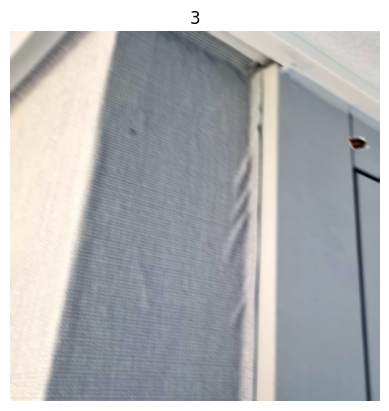

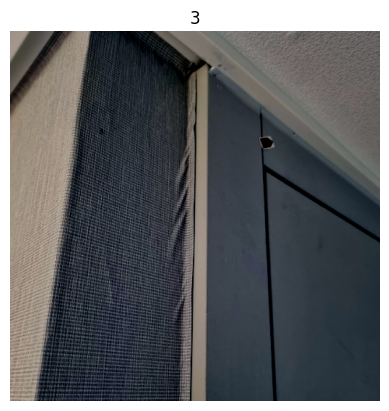

In [256]:
view_image(train_dataset[3456][0],train_dataset[3456][1])
view_image(val_dataset[3456][0],val_dataset[3456][1])

In [ ]:
class Network(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(Network, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
def train_model(model, optimizer, scheduler, device):

    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    fold_train_loss = 0
    fold_val_loss = 0
    fold_val_score = 0
    for epoch in range(1,CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
        fold_train_loss+=_train_loss
        fold_val_loss+=_val_loss
        fold_val_score+=_val_score
    if scheduler is not None:
        scheduler.step(_val_score)
        
        
    
    return fold_train_loss/CFG["EPOCHS"],fold_val_loss/CFG["EPOCHS"],fold_val_score/CFG["EPOCHS"]

In [ ]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='macro')
    
    return _val_loss, _val_score

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = CFG['SEED'])
best_model = None
best_score = 0
for fold, (train_idx, val_idx) in enumerate(skf.split(train['img_path'],train['label'])) :
    

    
    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], sampler=train_subsampler,num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], sampler=val_subsampler, num_workers=0)

    model = Network().to(device)

    optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.33, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
    
    fold_train_loss, fold_val_loss, fold_val_score = train_model(model,optimizer,scheduler,device)
    print(f'kfold [{fold+1}], Fold Train Loss : [{fold_train_loss:.5f}] Fold Val Loss : [{fold_val_loss:.5f}] Fold Val macro F1 Score : [{fold_val_score:.5f}]')

    if best_score < fold_val_score :
      best_model = model
      best_score = fold_val_score

In [ ]:
torch.save(model, f'/content/drive/MyDrive/paper/crossval_aug_0417_epoch{CFG["EPOCHS"]}_batch{CFG["BATCH_SIZE"]}_size{CFG["IMG_SIZE"]}_model.pt')

In [ ]:
test = pd.read_csv('./test.csv')

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, tmp_transforms,None,None)

In [ ]:
mean_test, std_test = calculate_norm(test_dataset,True)

In [ ]:
test_transform = A.Compose([
                            A.Normalize(mean_test, std_test, max_pixel_value=255.0, always_apply=False, p=1.0),
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            ToTensorV2()
                            ])

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform,None,None)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    return preds

In [ ]:
preds = inference(model, test_loader, device)

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit['label'] = preds

In [ ]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [ ]:
submit.to_csv(f'./crossval_aug_0417_epoch{CFG["EPOCHS"]}_batch{CFG["BATCH_SIZE"]}_size{CFG["IMG_SIZE"]}_submit.csv', index=False)